# **SLDS DoubleScroll YZ**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time as time
import random 
import reservoirpy.datasets as rsvp_d

from scipy.special import logsumexp
from scipy.stats import multivariate_normal, invwishart, matrix_normal

## Data generation

In [2]:
def Plot3D(xs, ys, zs, title, start, pt_number, lw):
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(xs[start:start+pt_number], ys[start:start+pt_number], zs[start:start+pt_number], lw=lw)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title(title)
    plt.show()
    


def Plot2D(xs, ys, zs, titl1, titl2, titl3, start, pt_number, lw):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15, 5))

    ax1.plot(xs[start:start+pt_number], ys[start:start+pt_number], lw=lw)
    ax1.set_title(titl1)
    ax1.set_xlabel("X Axis")
    ax1.set_ylabel("Y Axis")

    ax2.plot(xs[start:start+pt_number], zs[start:start+pt_number], lw=lw)
    ax2.set_title(titl2)
    ax2.set_xlabel("X Axis")
    ax2.set_ylabel("Z Axis")

    ax3.plot(ys[start:start+pt_number], zs[start:start+pt_number], lw=lw)
    ax3.set_title(titl3)
    ax3.set_xlabel("Y Axis")
    ax3.set_ylabel("Z Axis")

    plt.show()

In [3]:
t1 = time.time() #times the computation
arr = rsvp_d.doublescroll(2500, r1=1.2, r2=3.44, r4=0.193, ir=4.5e-05, beta=11.6, x0=[0.37926545, 0.058339, - 0.08167691], h=0.25)
xs = arr[:,0]
ys = arr[:,1]
zs = arr[:,2]
t2 = time.time()
print ('computation takes ',t2-t1,' seconds.')

/usr/local/lib/python3.10/dist-packages/reservoirpy/datasets/_chaos.py:430: RuntimeWarning: overflow encountered in sinh
  factor = (dV / r2) + ir * np.sinh(beta * dV)
/usr/local/lib/python3.10/dist-packages/reservoirpy/datasets/_chaos.py:431: RuntimeWarning: invalid value encountered in double_scalars
  dV1 = (V1 / r1) - factor
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_ivp/rk.py:109: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)


computation takes  0.42836880683898926  seconds.


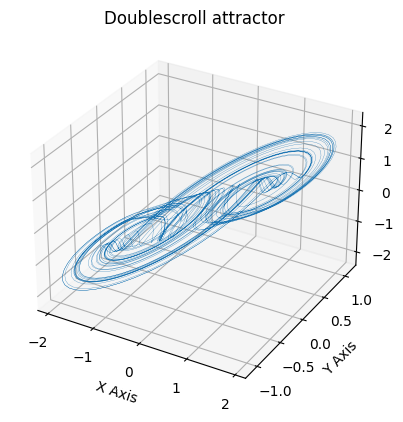

In [4]:
Plot3D(xs, ys, zs, "Doublescroll attractor", start=0, pt_number=2500, lw=0.2)

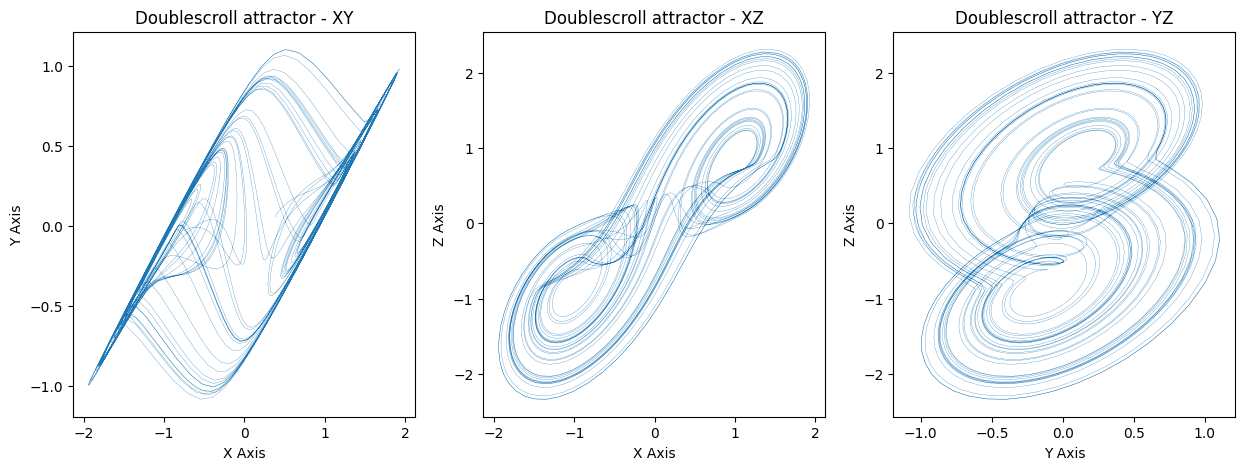

In [5]:
Plot2D(xs, ys, zs, "Doublescroll attractor - XY", "Doublescroll attractor - XZ", "Doublescroll attractor - YZ", start=0, pt_number=2500, lw=0.2)

In [9]:
y = np.delete(arr[:1000, :], 0, 1).copy()
y[:, 1] = y[:, 1]/2.5
y[:, 0] = y[:, 0]/1.2
y.shape

(1000, 2)

(-1.0, 1.0)

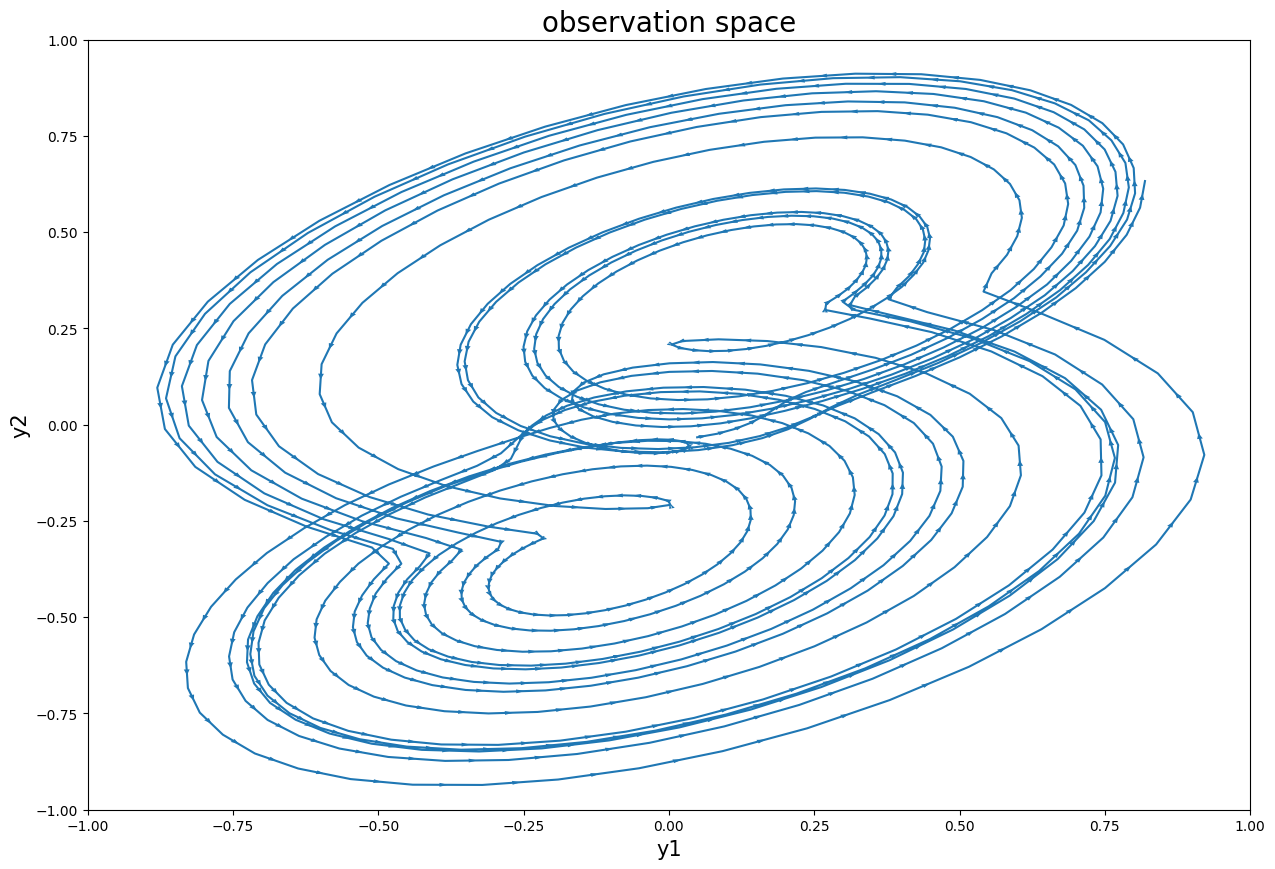

In [10]:
plt.rcParams["figure.figsize"] = (15,10)

plt.plot(y[:, 0], y[:, 1])

# code to add the arrows in the middle of the lines (fix head_width if needed)
for t in range(y.shape[0]-1):
    arr_mean_y1 = np.mean([y[t, 0], y[t+1, 0]])
    arr_mean_y2 = np.mean([y[t, 1], y[t+1, 1]])
    dy1 = y[t+1, 0] - y[t, 0]
    dy2 = y[t+1, 1] - y[t, 1]
    plt.arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.01)
    
plt.xlabel("y1", fontsize = 15)
plt.ylabel("y2", fontsize = 15)
plt.title("observation space", fontsize = 20)
plt.xlim(-1,1)
plt.ylim(-1,1)

## Inference

In [11]:
def plot_latent_state_dynamic(X1, X2, A, b, show_fixed_point = False, show_states = False, z = None):
    ###
    # plot vector fields given by A_k and b_k in the observation space
    ###
    
    # fixed points of the linear dynamics
    x_star = np.stack([np.dot(np.linalg.inv(np.eye(N, N) - A[k]), b[k]) for k in range(K)])

    n = X1.shape[0]
    X = np.stack([X1, X2])
    
    U = np.zeros((K, n, n))
    V = np.zeros((K, n, n))
    
    for k in range(K):
        for i in range(n):
            for j in range(n):
                U[k, i, j] = np.dot(A[k], X[:, i, j].reshape(-1, 2, 1))[0] + b[k, 0] - X[0, i, j]
                V[k, i, j] = np.dot(A[k], X[:, i, j].reshape(-1, 2, 1))[1] + b[k, 1] - X[1, i, j]
    
    fig, ax = plt.subplots(nrows = K, ncols = 1, figsize = (10, 6*K))
    for k in range(K):
        ax[k].quiver(X1, X2, U[k], V[k], width = 0.0025)
        if show_fixed_point:
            ax[k].scatter(x_star[k][0], x_star[k][1])

        if show_states:
            c = ["g" if i == 0 else "b" if i ==1 else "r" if i ==2 else "c" if i == 3 else "m" if i == 4 else "y" if i == 5 else "k" if i == 6 else "0" if i == 7 else "0.8" if i == 8 else "1" if i == 9 else i for i in z]
            #ax[k].scatter(y[:, 0], y[:, 1], color = c, s = 5)

            for t in range(T-1):
                ax[k].plot(y[t:t+2, 0], y[t:t+2, 1], c = c[t], lw = 0.5)
                arr_mean_y1 = np.mean([y[t, 0], y[t+1, 0]])
                arr_mean_y2 = np.mean([y[t, 1], y[t+1, 1]])
                dy1 = y[t+1, 0] - y[t, 0]
                dy2 = y[t+1, 1] - y[t, 1]
                ax[k].arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.02, color = c[t])
            '''
            # code to add the arrows in the middle of the lines (fix head_width if needed)
            for t in range(y.shape[0]-1):
                arr_mean_y1 = np.mean([y[t, 0], y[t+1, 0]])
                arr_mean_y2 = np.mean([y[t, 1], y[t+1, 1]])
                dy1 = y[t+1, 0] - y[t, 0]
                dy2 = y[t+1, 1] - y[t, 1]
                ax[k].arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.02, color = 'navy')
            '''
            

In [12]:
# to generate a random semipositive matrix
def generate_random_semipositive_matrix(dim, scale):

    tm = np.random.randn(dim, dim)
    test_matrix = scale*np.dot(tm, tm.T)
    
    return test_matrix

In [13]:
T = y.shape[0] # number of time steps
N = 2 # observation dim
K = 3 # latent dim

L = 40 # how many Gibbs iteration to do

### PRIORS
# IW(Q_k; S, nu)
# MN(A_hat_k; C, Q_k, V)

#S = generate_random_semipositive_matrix(N, 1)
S = 0.0001*np.eye(N, N)
nu = N
C = 0.1*np.random.randn(N, N+1)
#V = generate_random_semipositive_matrix(N+1, 1) # it should be a semipositive matrix, given what i found
V = 0.1*np.eye(N+1, N+1)

### INFERRED VARIABLES
# inferred samples of z
z_inf = np.zeros((L,T)).astype('int')
z_inf[0] = np.random.randint(K, size = T).astype('int')

# inferred samples of M
M_inf = np.zeros((L,K,K))
M_inf[0] = np.stack([np.random.dirichlet(tuple([1]*K)) for i in range(K)])
#M_inf[0] = np.copy(M)

A_hat_inf = np.zeros((L, K, N, N+1))
A_hat_inf[0] = 1*np.random.randn(K, N, N+1)
#A_hat_inf[0] = np.copy(A_hat) + 0.05*np.random.randn(K, N, N+1)

# inferred samples of Q_k
Q_inf = np.zeros((L,K,N,N))
Q_inf[0] = np.stack([0.0001*np.eye(N, N) for k in range(K)])# + np.copy(Q)# + 0.06*np.random.randn(K, N, N)

# inferred alpha parameters for the conditional dirichlet (to sample M)
alpha_inf = np.ones((L,K,K))

print(A_hat_inf[0])

[[[ 2.66905222 -0.55754394 -1.65357444]
  [ 0.24925222 -1.10149426  0.68360908]]

 [[ 0.47899793  0.08603318  0.31375398]
  [ 0.03605946  0.28556962  1.82342491]]

 [[-0.84545458  0.28659014 -1.41950572]
  [ 0.62086359  0.13796987 -1.62658948]]]


In [14]:
b_inf = A_hat_inf[0][:,:,0]
A_inf = A_hat_inf[0][:,:,1:]

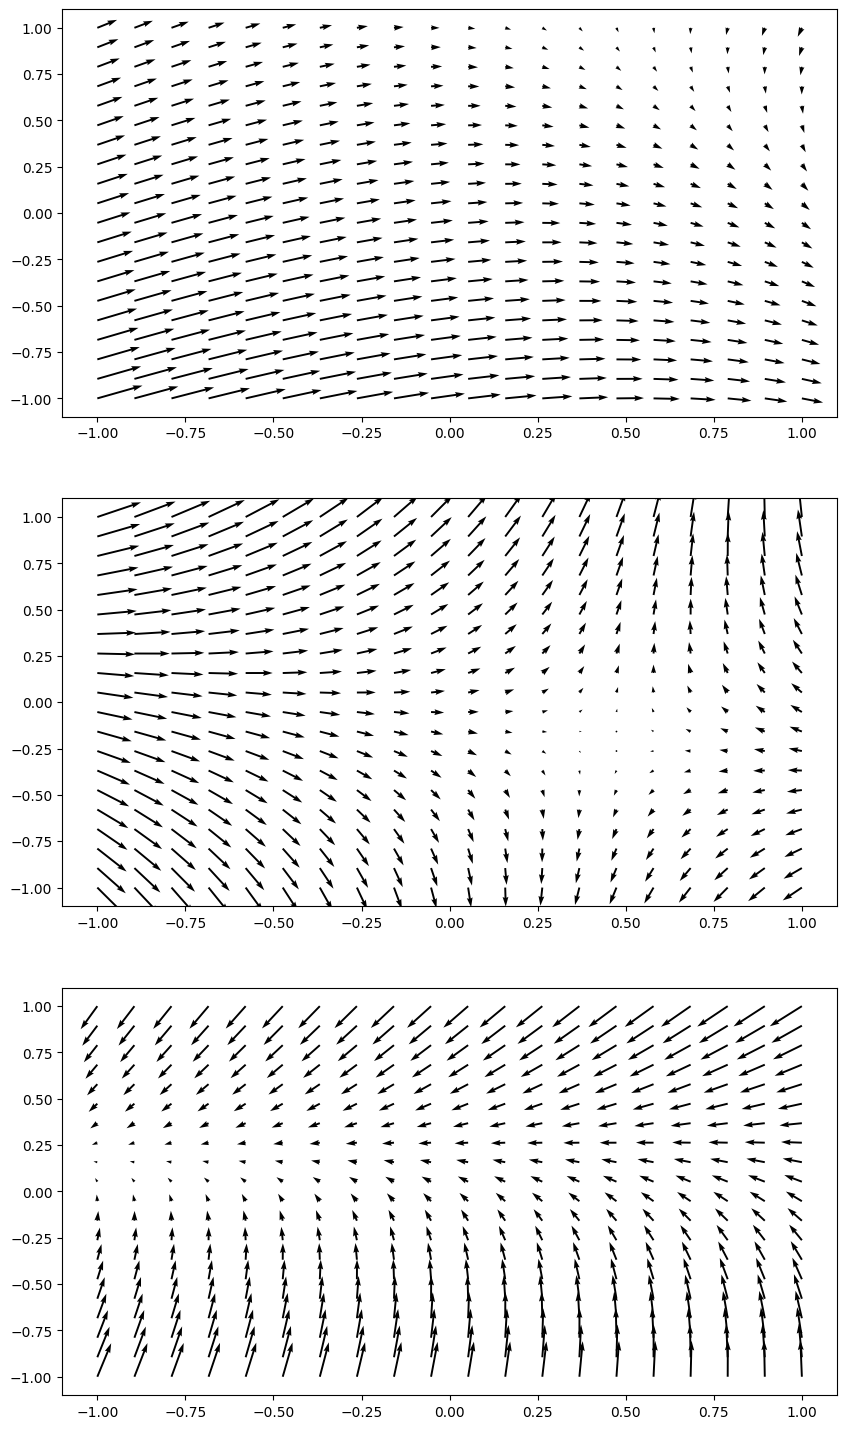

In [15]:
# create a grid just to display the dynamic systems
x1, x2 = np.linspace(-1,1,20), np.linspace(-1,1,20)
X1, X2 = np.meshgrid(x1, x2)

plot_latent_state_dynamic(X1, X2, A_inf, b_inf, show_fixed_point = False)

In [16]:
### function to try to implement forward-backward algo

def message_passing(M_inf_l, A_hat_inf_l, Q_inf_l):
    m = [np.array([1]*K)]
    log_m = [np.array([0]*K)]

    for t in reversed(range(1,T)): # T-1, T-2, ...
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        somm = np.zeros((K, K))
        m_t = np.zeros(K) # log of message at time t
        for k in range(K):
            for j in range(K):
                rv = multivariate_normal(np.zeros(N), Q_inf_l[j])
                x = y[t] - np.dot(A_hat_inf_l[j], y_hat)
                somm[k,j] = np.log(M_inf_l[k,j]) + rv.logpdf(x) + log_m[T-1-t][j]
        
        for k in range(K):
            m_t[k] = logsumexp(somm[k])
        
        log_m.append(m_t) # list of log messages

    log_p_z = np.zeros((T, K))
    z_inf_l = np.zeros(T).astype('int')

    for k in range(K):
        log_p_z[0, k] = log_m[T-1][k]
    log_p_z[0] = log_p_z[0] - logsumexp(log_p_z[0])
    z_inf_l[0] = np.random.choice(K, p = np.exp(log_p_z[0]))

    for t in range(1,T):
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        for k in range(K):
            rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
            x = y[t] - np.dot(A_hat_inf_l[k], y_hat)
            log_p_z[t, k] = np.log(M_inf_l[z_inf_l[t-1],k]) + rv.logpdf(x) + log_m[T-1-t][k]
        log_p_z[t] = log_p_z[t] - logsumexp(log_p_z[t])
        z_inf_l[t] = np.random.choice(K, p = np.exp(log_p_z[t]))

    return z_inf_l

In [18]:
### Gibbs sampling loop, update in sequence: z, M, A_hat, Q

for l in range(L-1):
    
    print("\n SAMPLE:", l)
    
    ### UPDATE z_t

    z_inf[l+1] = message_passing(M_inf[l], A_hat_inf[l], Q_inf[l])
    #z_inf[l+1] = myconditionals(M_inf[l], A_hat_inf[l], Q_inf[l], z_inf[l])

    ## UPDATE M
    
    # computing how many times there is a transition from state k to state j
    chi = np.zeros((K, K))
    
    for k in range(K):
        for j in range(K):
            somm = 0
            for t in range(T-1):
                if z_inf[l+1, t] == k and z_inf[l+1, t+1] == j:
                    somm += 1
            chi[k, j] = somm
    
    # updating conditional dirichlet parameters alpha initially set to [1,1,...,1] matrix
    alpha_inf[l+1] += chi
    
    # sampling rows of M from conditional distribution P(M|alpha)
    for k in range(K):
        M_inf[l+1, k] = np.random.dirichlet(tuple(alpha_inf[l+1, k]))
        
    #print(" \n alpha:")
    #print(alpha_inf[l+1])
    
    ### UPDATE MODEL PARAMETERS (see overleaf)
    
    # create data matrix grouped by state, all y_t where z_t = k
    Y = [[] for k in range(K)]

    # create data matrix grouped by state, all y_{t-1} where z_t = k
    Y_bar = [[] for k in range(K)]

    # number of observations belonging to a given state k
    N_k = np.zeros(K)
    
    #print("\n N_k:")
    
    for k in range(K):
        for t in range(1, T):
            if z_inf[l+1, t] == k:
                Y[k].append(y[t])
                Y_bar[k].append(np.concatenate([np.array([1]), y[t-1]]))
    
        N_k[k] = len(Y[k])
        #print(N_k[k])
        if N_k[k] != 0:
            Y[k] = np.stack(Y[k]).T
            Y_bar[k] = np.stack(Y_bar[k]).T
        
    # sufficient statistics for MNIW (see overleaf)
    
    S_ybar_ybar = np.zeros((K, N+1, N+1))
    S_y_ybar = np.zeros((K, N, N+1))
    S_y_y = np.zeros((K, N, N))
    S_y_given_ybar = np.zeros((K, N, N))
    
    for k in range(K):
        if N_k[k] != 0:
            #print(Y_bar[k].shape)
            S_ybar_ybar[k] = np.dot(Y_bar[k], Y_bar[k].T) + V
            S_y_ybar[k] = np.dot(Y[k], Y_bar[k].T) + np.dot(C, V)
            S_y_y[k] = np.dot(Y[k], Y[k].T) + C @ V @ C.T
            S_y_given_ybar[k] = S_y_y[k] - S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]) @ S_y_ybar[k].T
    
    # sampling from IW and MN with updated hyperparameters
    
    for k in range(K):
        if N_k[k] != 0:
            rv_iw = invwishart(nu + N_k[k], S + S_y_given_ybar[k])
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            
            # INVERSE OF Q OR NOT?
            rv_mn = matrix_normal(S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]), Q_inf[l+1, k], np.linalg.inv(S_ybar_ybar[k]))
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)
        else:
            # keep the same o sample a fresh new? (from the priors maybe)
            rv_iw = invwishart(nu, S)
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            rv_mn = matrix_normal(C, Q_inf[l+1, k], V)
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)

            #Q_inf[l+1, k] = Q_inf[l, k] 
            #A_hat_inf[l+1, k] = 1*np.random.randn(N, N+1)


 SAMPLE: 0

 SAMPLE: 1

 SAMPLE: 2

 SAMPLE: 3

 SAMPLE: 4

 SAMPLE: 5

 SAMPLE: 6

 SAMPLE: 7

 SAMPLE: 8

 SAMPLE: 9

 SAMPLE: 10

 SAMPLE: 11

 SAMPLE: 12

 SAMPLE: 13

 SAMPLE: 14

 SAMPLE: 15

 SAMPLE: 16

 SAMPLE: 17

 SAMPLE: 18

 SAMPLE: 19

 SAMPLE: 20

 SAMPLE: 21

 SAMPLE: 22

 SAMPLE: 23

 SAMPLE: 24

 SAMPLE: 25

 SAMPLE: 26

 SAMPLE: 27

 SAMPLE: 28

 SAMPLE: 29

 SAMPLE: 30

 SAMPLE: 31

 SAMPLE: 32

 SAMPLE: 33

 SAMPLE: 34

 SAMPLE: 35

 SAMPLE: 36

 SAMPLE: 37

 SAMPLE: 38


In [19]:
print(z_inf[0])
print(z_inf[1])
print(z_inf[-1])
print(np.mean(z_inf, axis = 0)) 
unique, counts = np.unique(z_inf[50:], return_counts=True)
print(dict(zip(unique, counts)))

[1 2 0 1 2 0 0 0 1 1 0 2 1 1 1 1 0 0 1 1 1 2 1 0 2 2 1 0 1 1 0 2 1 1 0 1 1
 0 1 0 2 1 0 2 0 1 2 1 2 2 2 2 0 1 0 0 2 0 1 1 2 1 2 1 0 2 2 1 1 2 1 2 1 1
 1 2 1 2 2 1 2 0 1 0 0 1 0 1 1 0 0 1 2 2 0 2 1 0 0 0 1 2 0 1 1 1 0 1 0 0 1
 1 0 2 0 1 2 0 1 0 2 0 0 0 1 2 2 0 1 0 0 2 0 0 0 0 1 1 1 0 2 2 1 2 0 2 1 1
 0 2 0 1 0 1 0 0 2 1 0 1 2 2 0 1 0 1 2 2 1 2 1 0 2 1 0 0 2 2 1 0 2 2 0 1 1
 0 1 2 0 0 2 1 1 0 1 0 2 2 2 2 2 0 1 1 1 1 0 0 1 0 1 2 0 0 1 2 1 0 0 2 2 0
 1 2 2 1 0 0 1 0 1 2 2 0 0 2 2 1 1 1 1 1 2 0 2 2 2 2 1 0 1 2 2 0 0 1 2 0 2
 0 0 2 0 0 1 0 2 1 2 2 1 0 1 1 0 1 2 0 2 1 2 0 1 2 2 1 1 0 2 1 0 1 1 2 2 0
 1 2 0 0 1 0 1 2 2 2 2 1 2 1 2 1 1 1 2 2 2 0 0 0 0 2 0 2 2 0 1 1 2 1 0 1 0
 1 0 0 1 1 0 0 1 1 2 2 0 1 0 0 0 2 2 1 0 2 0 0 2 2 1 2 1 0 0 2 1 1 2 2 1 2
 0 2 1 0 0 2 0 0 2 0 2 2 1 2 2 0 1 0 2 2 2 0 0 1 1 2 0 2 1 0 0 0 2 1 2 2 1
 1 1 0 2 2 1 1 0 2 0 0 1 2 2 0 1 2 2 1 0 1 0 2 1 0 2 0 2 1 0 0 0 2 2 1 1 0
 2 1 2 2 2 2 2 2 1 0 2 2 2 1 0 0 0 0 2 1 0 0 1 1 0 0 0 0 1 2 2 0 2 2 2 1 2
 1 0 2 0 1 2 1 2 0 1 1 0 

In [20]:
print(np.mean(M_inf, axis = 0))
eigw_inf, eigv_inf = np.linalg.eig(np.mean(M_inf, axis = 0).T)
print(eigv_inf.real[:, 0]/np.sum(eigv_inf.real[:, 0]))

[[0.31587309 0.36396955 0.32015736]
 [0.01794024 0.97751756 0.00454221]
 [0.24945564 0.38962002 0.36092434]]
[0.03325891 0.9433744  0.02336669]


In [21]:
print(np.mean(A_hat_inf, axis = 0))

[[[ 1.50327007e-01 -1.22474842e-01  5.59405629e-02]
  [-3.20031341e-02  5.74775466e-02  1.36901282e-01]]

 [[ 1.17729016e-02  1.01565907e+00 -9.12986588e-02]
  [ 8.72340483e-04  1.24023098e-01  9.68175665e-01]]

 [[ 5.40318649e-02 -8.88230891e-02  6.42671009e-02]
  [-3.52636592e-02  8.38595238e-02  1.01201714e-01]]]


In [22]:
Q_inf_av = np.mean(Q_inf, axis = 0)
for k in range(K):
    print(Q_inf_av[k])
    eigw_q, _ = np.linalg.eig(Q_inf_av[k])
    print(eigw_q)

[[ 0.006837   -0.00071641]
 [-0.00071641  0.00439263]]
[0.0070315  0.00419814]
[[1.99271539e-03 9.89446875e-05]
 [9.89446875e-05 7.86926841e-05]]
[1.99781670e-03 7.35913717e-05]
[[0.00387122 0.00141706]
 [0.00141706 0.00423118]]
[0.00262276 0.00547965]


In [23]:
#b_inf_av = np.mean(A_hat_inf[L//2:], axis = 0)[:,:,0]
#A_inf_av = np.mean(A_hat_inf[L//2:], axis = 0)[:,:,1:]
b_inf_av = A_hat_inf[-1][:,:,0]
A_inf_av = A_hat_inf[-1][:,:,1:]

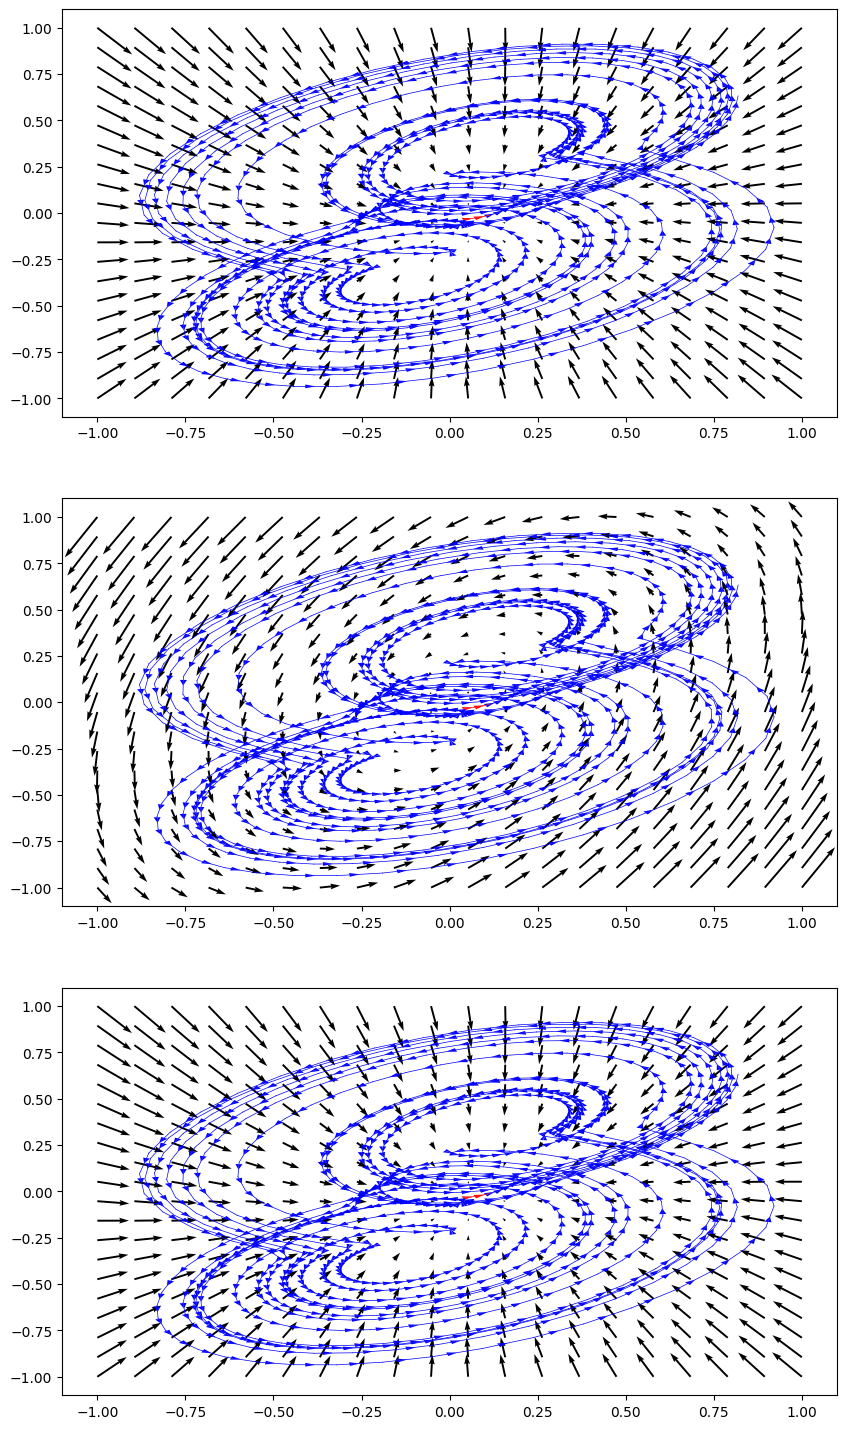

In [24]:
# create a grid just to display the dynamic systems
x1, x2 = np.linspace(-1,1,20), np.linspace(-1,1,20)
X1, X2 = np.meshgrid(x1, x2)

plot_latent_state_dynamic(X1, X2, A_inf_av, b_inf_av, show_fixed_point = False, show_states = True, z = z_inf[10])